# Human Activity Recognition
This notebook provides some guidelines for building a classifier for the MotionSense dataset

In [1]:
!pip install pandas

In [2]:
!pip install scikit-learn

In [3]:
!pip install torch

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Generate time-series data
The original MotionSense dataset comes in a slightly cumbersome format, but the authors do provide a few functions to produce Pandas DataFrames with control over what is produced. For our purposes we are not concerned with all of the target data, as we only need to know the activity that was being recorded. 

In [5]:
def get_ds_infos():
    """
    Read the file includes data subject information.

    EEE4114: Technically we do not need these data, as we are not concerned about identifying the subjects. 
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains information about data subjects' attributes 
    """ 

    dss = pd.read_csv("./data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset. 

    EEE4114F: Choose sensors that you think are useful or would like to include in training. 
    You can choose all of them, or you could opt to try a limited set of input features
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    EEE4114F: This defines what data you would like to include for a given set.  

    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimension of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeled dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+1)) # "1" --> [act] we do not need the other labels
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = './A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

You would need to decide what to include in your dataset, for example if you want to try a reduce dataset with only a few sensors then you can alter the `sdt` list. 

In [6]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(767660, 7)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0


# Data Pre-processing
There are numerous approaches to solving this task and your choice of algorithm will determine what form your input data should take. For example, a feed-forward neural network could be used, but what type of representation would make sense? Without being able to account for the temporal structure of the data, feed-forward networks might fail. One way around this is to potentially use summarized statistics about the data to simplify the features in a way that is not reliant on temporal information. E.g. instead of the raw signal for the acceleration, what if you worked with the mean? This might not be the best approach, compared to other algorithms, but it could be useful for a feed-forward network.

what about convolutional neural networks? Well, you could use 1D convolutions directly on time-series data which would then result in fewer model parameters compared to a fully-connected network, with the added benefit of retaining temporal information. Alternatively you could look to transform the time-series data into 2D data using something such as an FFT to produce a spectogram. Or for something simpler you can create fixed windows to divide your dataset into chunks of 2D data e.g. for 6 sensors and a window of 400 samples you would generate a 6 x 400 input. 

In [7]:
def create_sliding_windows(df, window_size=100, stride=50):
    features = df.columns[:-1]
    X, y = [], []
    for i in range(0, len(df) - window_size, stride):
        window = df.iloc[i:i+window_size]
        label = window["act"].mode()[0]  # most frequent label in the window
        X.append(window[features].values)
        y.append(label)
    return np.array(X), np.array(y)


In [8]:
# Apply windowing
X, y = create_sliding_windows(dataset, window_size=100, stride=50)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])
X_train = scaler.fit_transform(X_train).reshape(-1, 100, X.shape[2])
X_test = scaler.transform(X_test).reshape(-1, 100, X.shape[2])


# Pytorch Dataset
If using Pytorch it is useful to create datasets using their dataset structures. This may require modification if using additional transformations, or formats

In [9]:
class HARWindowedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = HARWindowedDataset(X_train, y_train)
test_ds = HARWindowedDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


# Resampling
You can split the dataset using sklearn, but you need to take care with your specific data. For example, randomly splitting raw sensor data will result in jumbled time-series signals. 

In [10]:
#X = dataset[dt_list[0]] # You could collect the input and target data as separate dataframes
#Y = dataset.act

In [11]:
# You may be tempted to use train_test_split directly. But if using raw sensor data this would randomize the signals and not retain the order. 
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) 

In [12]:
#X_train.head() 

Notice the indeces are all jumbled? If using windowed data the usual splitting methods work, as each window retains the order of sensor values, as long as you split the data along the correct axis. 

If using summarized data e.g. taking the mean, max, min etc. as input features rather than the raw data then you should be fine using train_test_split.

If working with raw sensor data there is an sklearn fuction for splitting time series data to make splitting raw signals easier if you want to work with that instead.

In [13]:
# Here is an example of the TimeSeriesSplit. It does create cross-validation data by default. 
#ts_cv = TimeSeriesSplit(
#    n_splits=5,
 #   gap=20,
  #  max_train_size=10000,
   # test_size=1000
#)

#all_splits = list(ts_cv.split(X ,Y)) # These are indices, not the data itself.

Once you have the indices you can sample the data

In [14]:
#X.iloc[all_splits[0][0]].head() # This is the training input data from the first split

In [15]:
#Y.iloc[all_splits[0][0]].head() # This is the training target data from the first split. You can see the indices still match, and arre ordered correctly.

Once you have your splits, you can convert them to Pytorch datasets for easier loading. Technically you could offload the sampling methods to Pytorch samplers, but this can be trickier to implement.

In [16]:
#train_1 = MotionSense(X.iloc[all_splits[0][0]].reset_index(drop=True), 
#                      Y.iloc[all_splits[0][0]].reset_index(drop=True)) # reset_index is to make sure each new set is indexed from 0
#train_1_loader = DataLoader(train_1, batch_size=5)  # Will load data in batches. Batching raw signals can be problematic if it cuts-off a given signal, or stitches it together with other signals etc.

# Models
As mentioned previously there are a few options for the types of models you end up using.

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use the last output
        return self.fc(out)

input_dim = X_train.shape[2]
model = LSTMClassifier(input_dim=input_dim, hidden_dim=64, output_dim=len(np.unique(y)))


# Training
With your model defined you will need to decide on an optimizer used to perform parameter updates. The choice is yours, but for the most part default optimizers like Adam should work for CNNs, although SGD can be more stable but take longer to train. 

You can then load in data, for example if using the loader described before the loop shown below will iterate through batches of data. 

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(55):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}")


Epoch 1: Loss = 1.1048
Epoch 2: Loss = 0.9542
Epoch 3: Loss = 0.9052
Epoch 4: Loss = 0.7422
Epoch 5: Loss = 0.7004
Epoch 6: Loss = 0.6648
Epoch 7: Loss = 0.6699
Epoch 8: Loss = 0.5833
Epoch 9: Loss = 0.6173
Epoch 10: Loss = 0.5700
Epoch 11: Loss = 0.6015
Epoch 12: Loss = 0.6375
Epoch 13: Loss = 0.6176
Epoch 14: Loss = 0.5481
Epoch 15: Loss = 0.4969
Epoch 16: Loss = 0.4541
Epoch 17: Loss = 0.4004
Epoch 18: Loss = 0.3522
Epoch 19: Loss = 0.3216
Epoch 20: Loss = 0.3256
Epoch 21: Loss = 0.2883
Epoch 22: Loss = 0.2738
Epoch 23: Loss = 0.2718
Epoch 24: Loss = 0.2416
Epoch 25: Loss = 0.2246
Epoch 26: Loss = 0.2359
Epoch 27: Loss = 0.2062
Epoch 28: Loss = 0.1997
Epoch 29: Loss = 0.2415
Epoch 30: Loss = 0.2056
Epoch 31: Loss = 0.2316
Epoch 32: Loss = 0.2128
Epoch 33: Loss = 0.1897
Epoch 34: Loss = 0.1689
Epoch 35: Loss = 0.1857
Epoch 36: Loss = 0.1531
Epoch 37: Loss = 0.1948
Epoch 38: Loss = 0.1822
Epoch 39: Loss = 0.1798
Epoch 40: Loss = 0.1582
Epoch 41: Loss = 0.1444
Epoch 42: Loss = 0.1997
E

# Evaluation
Make sure to correctly evaluate your models. Justify your methods given your particular model and data used e.g. if you use random holdout, is it justified? What do your performance metrics tell you e.g. was the model overfitting, underfitting, are their early stages in the training process where the model performs well compared to the end of training, which model do you choose to save, are the model outputs "reasonable" i.e. are there errors that might make sense given the data? 

In [19]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 95.31%


<Figure size 600x600 with 0 Axes>

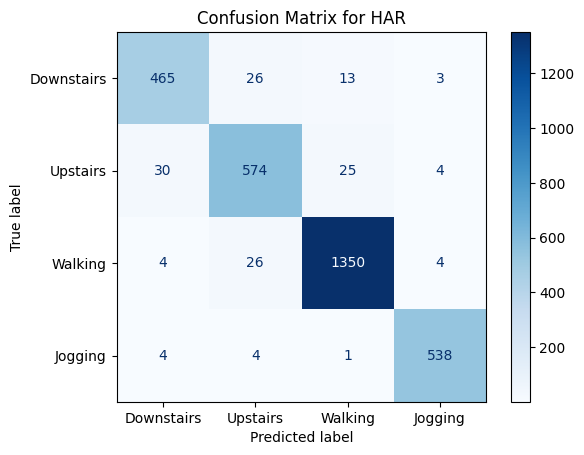

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define class names in the correct order
class_names = ['Downstairs', 'Upstairs', 'Walking', 'Jogging']

# Collect all predictions and true labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for HAR")
plt.grid(False)
plt.show()


In [21]:
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [22]:
from sklearn.metrics import classification_report

# class_names must match your label encoding order
class_names = ['Downstairs', 'Upstairs', 'Walking', 'Jogging']

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

  Downstairs       0.92      0.92      0.92       507
    Upstairs       0.91      0.91      0.91       633
     Walking       0.97      0.98      0.97      1384
     Jogging       0.98      0.98      0.98       547

    accuracy                           0.95      3071
   macro avg       0.95      0.95      0.95      3071
weighted avg       0.95      0.95      0.95      3071

